# 日経平均株価 15分足

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import get_name_15min_chart, get_name_15min_chart_usd

In [3]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-01-19 09:00:00+09:00,53390.050781,53547.281250,53266.609375,53465.531250,0,0.0,0.0
2026-01-19 09:15:00+09:00,53463.738281,53480.199219,53236.808594,53255.199219,0,0.0,0.0
2026-01-19 09:30:00+09:00,53257.410156,53299.691406,53189.968750,53245.101562,0,0.0,0.0
2026-01-19 09:45:00+09:00,53253.500000,53381.371094,53235.398438,53260.640625,0,0.0,0.0
2026-01-19 10:00:00+09:00,53255.339844,53302.941406,53218.300781,53293.871094,0,0.0,0.0
2026-01-19 10:15:00+09:00,53285.820312,53319.101562,53231.390625,53231.390625,0,0.0,0.0


In [4]:
dt_start = df.index[0]
dt_end = pd.to_datetime(
    f"{dt_start.year:04d}-{dt_start.month:02d}-{dt_start.day:02d} 15:30:00+09:00"
).tz_convert("Asia/Tokyo")
dt_start, dt_end

(Timestamp('2026-01-19 09:00:00+0900', tz='Asia/Tokyo'),
 Timestamp('2026-01-19 15:30:00+0900', tz='Asia/Tokyo'))

In [5]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 50168.11 # 12/15 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2026-01-13 00:00:00+09:00    53549.160156
2026-01-14 00:00:00+09:00    54341.230469
2026-01-15 00:00:00+09:00    54110.500000
2026-01-16 00:00:00+09:00    53936.171875
2026-01-19 00:00:00+09:00    53231.390625
Name: Close, dtype: float64


Date
2026-01-16 00:00:00+09:00    53936.171875
Name: Close, dtype: float64

In [6]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-546.12


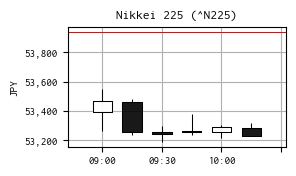

In [7]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

In [8]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

In [9]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-01-16 09:00:00+09:00,158.582001,158.598007,158.513000,158.556000,0,0.0,0.0
2026-01-16 09:15:00+09:00,158.548996,158.595993,158.544006,158.587006,0,0.0,0.0
2026-01-16 09:30:00+09:00,158.593002,158.610001,158.533997,158.582993,0,0.0,0.0
2026-01-16 09:45:00+09:00,158.578003,158.703995,158.572998,158.654999,0,0.0,0.0
2026-01-16 10:00:00+09:00,158.649002,158.682007,158.539993,158.544006,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-19 09:30:00+09:00,157.664993,157.684006,157.511993,157.535995,0,0.0,0.0
2026-01-19 09:45:00+09:00,157.531006,157.604996,157.436005,157.475006,0,0.0,0.0
2026-01-19 10:00:00+09:00,157.473007,157.621994,157.438995,157.507996,0,0.0,0.0


In [10]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2026-01-19 09:00:00+09:00,338.273552,339.269747,337.491440,338.751788
2026-01-19 09:15:00+09:00,339.094910,339.199314,337.655604,337.772247
2026-01-19 09:30:00+09:00,338.065024,338.333415,337.636923,337.986892
2026-01-19 09:45:00+09:00,338.171125,338.983134,338.056176,338.216470
2026-01-19 10:00:00+09:00,338.111977,338.414194,337.876821,338.356608
2026-01-19 10:15:00+09:00,338.451597,338.662987,338.105880,338.105880


In [11]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2026-01-16 15:15:00+09:00


np.float64(158.38400268554688)

前日終値（ドル換算） 340.54052783401386


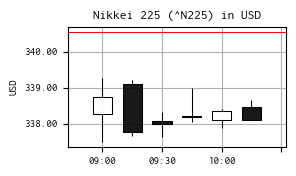

In [12]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()